In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install librosa numpy scikit-learn tensorflow

In [ ]:
pip install --upgrade librosa resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.2 MB/s eta 0:00:00


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5"

In [ ]:
import os, glob


# Try your explicit path first (edit if you already know it)
MODEL_PATH = MODEL_PATH if 'MODEL_PATH' in globals() else ""
candidates = []

# Add places to search (edit/add paths you actually use)
search_roots = [
    "/content/drive/MyDrive",     # Colab Drive
    os.getcwd(),                  # current working directory
]

for root in search_roots:
    if os.path.isdir(root):
        candidates += glob.glob(os.path.join(root, "**", "*.h5"), recursive=True)
        candidates += glob.glob(os.path.join(root, "**", "*.keras"), recursive=True)

# If your explicit MODEL_PATH doesn't exist, try to pick a found one
if not (MODEL_PATH and os.path.isfile(MODEL_PATH)):
    if candidates:
        # Prefer files that look like emotion models
        ranked = sorted(candidates, key=lambda p: ("emotion" not in os.path.basename(p).lower(), len(p)))
        MODEL_PATH = ranked[0]
        print(f"✅ Using discovered model: {MODEL_PATH}")
    else:
        raise FileNotFoundError(
            "Couldn't find a model file. Set MODEL_PATH to a real file, e.g.\n"
            'MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5"\n'
            "If you haven't saved one yet, train and save with:\n"
            'model.save("/content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5")'
        )

assert os.path.isfile(MODEL_PATH), f"Model not found: {MODEL_PATH}"

In [ ]:
import os
print(os.path.isfile(MODEL_PATH), MODEL_PATH)

True /content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5


In [ ]:
import os, re, glob, math, random
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# PATHS

FILE_PATH    = "/content/drive/MyDrive/1001_DFA_SAD_XX.wav"
MODEL_PATH   = "/content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5"
CLASSES_PATH = "/content/drive/MyDrive/Colab Notebooks/models/classes.txt"
CACHE_PATH   = "/content/drive/MyDrive/Colab Notebooks/models/ser_cache_4cls_fast.npz"

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CLASSES_PATH), exist_ok=True)

# CONSTANTS
# CONFIG
TARGET_SR   = 16000
WIN_MS      = 25
HOP_MS      = 10
N_MELS      = 128
SEGMENT_S   = 3.0

TEST_SIZE   = 0.15
VAL_SIZE    = 0.15
BATCH_SIZE  = 32
EPOCHS      = 30
SEED        = 42
AUG_SEGMENTS_PER_FILE = 3
OVERLAP     = 0.5


In [ ]:
import os, glob
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import random

# CONSTANTS
# CONFIG
TARGET_SR   = 16000
WIN_MS      = 25
HOP_MS      = 10
N_MELS      = 128
SEGMENT_S   = 3.0

TEST_SIZE   = 0.15
VAL_SIZE    = 0.15
BATCH_SIZE  = 32
EPOCHS      = 10
SEED        = 42
AUG_SEGMENTS_PER_FILE = 3
OVERLAP     = 0.5

# SPEED TOGGLES (Overrides for quick experiments)
FAST_MODE = True
USE_MIXED_PRECISION = True
MAX_FILES_PER_CLASS = 60

# Apply FAST overrides
if FAST_MODE:
    N_MELS = 64
    HOP_MS = 20
    SEGMENT_S = 2.0
    AUG_SEGMENTS_PER_FILE = 1
    OVERLAP = 0.0
    BATCH_SIZE = 64
    EPOCHS = 8

# Derived constants (recompute after FAST changes)
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

HOP_S       = HOP_MS / 1000.0
WIN_S       = WIN_MS / 1000.0
HOP_SAMPLES = int(TARGET_SR * HOP_S)
WIN_SAMPLES = int(TARGET_SR * WIN_S)
MAX_FRAMES  = int(np.floor(SEGMENT_S / HOP_S)) + 1
INPUT_SHAPE = (N_MELS, MAX_FRAMES, 1)

# Mixed precision
if USE_MIXED_PRECISION and tf.config.list_physical_devices('GPU'):
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled")


def load_labels_file(path):
    if os.path.isfile(path):
        with open(path, "r", encoding="utf-8") as f:
            return [ln.strip() for ln in f if ln.strip()]
    return None

def save_labels_file(path, labels):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        for lab in labels:
            f.write(f"{lab}\n")

def logmel(y, sr, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=WIN_SAMPLES,
        hop_length=HOP_SAMPLES,
        win_length=WIN_SAMPLES,
        n_mels=n_mels,
        fmin=30, fmax=8000,
        power=2.0
    )
    return librosa.power_to_db(S, ref=np.max)

def segment_logmel(M, max_frames=MAX_FRAMES, overlap=0.5):
    T = M.shape[1]
    if T <= max_frames:
        pad = max_frames - T
        if pad > 0:
            M_pad = np.pad(M, ((0, 0), (0, pad)), mode="constant", constant_values=M.min())
        else:
            M_pad = M[:, :max_frames]
        return np.expand_dims(M_pad, axis=0)

    step = int(max_frames * (1.0 - overlap))
    step = max(1, step)
    segments = []
    for start in range(0, T - max_frames + 1, step):
        segments.append(M[:, start:start + max_frames])
    if (T - max_frames) % step != 0:
        segments.append(M[:, -max_frames:])
    return np.stack(segments, axis=0)

def normalize_per_segment(X):
    X = X.astype(np.float32)
    eps = 1e-6
    mean = X.mean(axis=(1, 2), keepdims=True)
    std  = X.std(axis=(1, 2), keepdims=True)
    return (X - mean) / (std + eps)

def extract_segments_from_file(path, segments_per_file=AUG_SEGMENTS_PER_FILE, overlap=OVERLAP):
    try:
        y, _ = librosa.load(path, sr=TARGET_SR, mono=True)
        y, _ = librosa.effects.trim(y, top_db=30)
        if y.size == 0:
            return np.empty((0, N_MELS, MAX_FRAMES)), False
        M = logmel(y, TARGET_SR)  # (mel, T)
        segs = segment_logmel(M, max_frames=MAX_FRAMES, overlap=overlap)
        if segs.shape[0] == 0:
            return np.empty((0, N_MELS, MAX_FRAMES)), False
        if segs.shape[0] > segments_per_file > 0:
            idx = rng.choice(segs.shape[0], size=segments_per_file, replace=False)
            segs = segs[idx]
        return segs, True
    except Exception as e:
        print(f"⚠️ Skipping {os.path.basename(path)} due to error: {e}")
        return np.empty((0, N_MELS, MAX_FRAMES)), False

def make_dataset_from_folder(root_dir):
    assert os.path.isdir(root_dir), f"ERROR: {root_dir} is not a valid directory!"

    classes = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')])
    if not classes:
        raise ValueError(f"No class subfolders found inside {root_dir}")

    files, labels = [], []
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        wavs = sorted(glob.glob(os.path.join(cls_dir, "*.wav")))
        if not wavs:
            print(f"No .wav files under {cls_dir}")
        for w in wavs:
            files.append(w)
            labels.append(cls)

    print(f"Found {len(files)} files across {len(classes)} classes: {classes}")

    le = LabelEncoder()
    le.fit(classes)
    y_idx = le.transform(labels)

    X_list, y_list = [], []
    for fp, yi in zip(files, y_idx):
        segs, ok = extract_segments_from_file(fp)
        if not ok:
            continue
        X_list.append(segs)
        y_list.append(np.full((segs.shape[0],), yi))

    if not X_list:
        raise ValueError("No valid audio segments produced. Check your dataset and audio files.")

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    X = normalize_per_segment(X)
    X = X[..., np.newaxis]   # (N, mel, frames, 1)
    y_cat = to_categorical(y, num_classes=len(classes))

    print(f"Dataset: X={X.shape}, y={y_cat.shape}")
    return X, y_cat, classes

In [ ]:
def build_cnn(input_shape, num_classes):
    m = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), padding="same"), BatchNormalization(), Activation("relu"),
        MaxPooling2D((2,2)), Dropout(0.2),

        Conv2D(64, (3,3), padding="same"), BatchNormalization(), Activation("relu"),
        MaxPooling2D((2,2)), Dropout(0.25),

        Conv2D(128, (3,3), padding="same"), BatchNormalization(), Activation("relu"),
        MaxPooling2D((2,2)), Dropout(0.3),

        GlobalAveragePooling2D(),
        Dense(128), BatchNormalization(), Activation("relu"), Dropout(0.3),
        Dense(num_classes, activation="softmax"),
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m


In [ ]:
def train_and_evaluate():
    X, y, classes = make_dataset_from_folder(DATA_DIR)

    # stratified splits
    y_idx = np.argmax(y, axis=1)
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=(TEST_SIZE + VAL_SIZE), random_state=SEED, stratify=y_idx)
    y_tmp_idx = np.argmax(y_tmp, axis=1)
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=(TEST_SIZE/(TEST_SIZE+VAL_SIZE)),
        random_state=SEED, stratify=y_tmp_idx)

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    model = build_cnn(INPUT_SHAPE, num_classes=y.shape[1])

    callbacks = [
        EarlyStopping(patience=6, restore_best_weights=True, monitor="val_accuracy", mode='max'),
        ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5, monitor="val_loss"),
        ModelCheckpoint(MODEL_PATH, monitor="val_accuracy", save_best_only=True, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callbacks
    )

    # Test metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n🧪 Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.2f}")

    # Detailed report - moved to a separate cell for clarity and flexibility
    # y_pred = model.predict(X_test, verbose=0)
    # y_true_labels = np.argmax(y_test, axis=1)
    # y_pred_labels = np.argmax(y_pred, axis=1)
    # print("\nClassification report:")
    # print(classification_report(y_true_labels, y_pred_labels, target_names=None, digits=4))

    # Save labels
    save_labels_file(CLASSES_PATH, [str(i) for i in range(y.shape[1])])  # or use your class names
    print(f"Saved model to: {MODEL_PATH}")
    print(f"Saved classes to: {CLASSES_PATH}")

    return X_test, y_test, model, classes

In [ ]:
def _parse_model_input_shape(model):
    in_shape = model.input_shape
    if isinstance(in_shape, list):
        in_shape = in_shape[0]
    if len(in_shape) == 4:          # (None, H, W, C)
        _, H_exp, W_exp, C_exp = in_shape
    elif len(in_shape) == 3:        # (None, H, W)
        _, H_exp, W_exp = in_shape; C_exp = 1
    else:
        raise ValueError(f"Unexpected input shape: {in_shape}")
    return H_exp, W_exp, C_exp

def crop_or_pad_frames(X2d, frames_target, pad_value):
    mel, frames = X2d.shape
    if frames == frames_target:
        return X2d
    if frames < frames_target:
        pad = frames_target - frames
        return np.pad(X2d, ((0,0), (pad//2, pad - pad//2)),
                      mode="constant", constant_values=pad_value)
    start = (frames - frames_target)//2
    return X2d[:, start:start+frames_target]

def predict_emotion(file_path, model_path, classes_path):
    assert os.path.isfile(file_path), f"Audio not found: {file_path}"
    assert os.path.isfile(model_path), f"Model not found: {model_path}"

    labels = load_labels_file(classes_path)
    model  = load_model(model_path, compile=False)
    H_exp, W_exp, C_exp = _parse_model_input_shape(model)
    if labels is None:
        labels = [f"class_{i}" for i in range(model.output_shape[-1])]
    print(f"Model expects (H,W,C)=({H_exp},{W_exp},{C_exp})")

    y, _ = librosa.load(file_path, sr=TARGET_SR, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    if y.size == 0:
        raise ValueError("Audio seems empty after trimming.")

    # Adjust mel bins if needed to match model height/width
    n_mels_used = H_exp if N_MELS not in (H_exp, W_exp) else N_MELS
    if n_mels_used != N_MELS:
        print(f"Adjusting mel bins from {N_MELS} -> {n_mels_used} to match model.")
    M = logmel(y, TARGET_SR, n_mels=n_mels_used)

    if n_mels_used == H_exp:
        frames_needed = W_exp
        transpose_needed = False
    elif n_mels_used == W_exp:
        frames_needed = H_exp
        transpose_needed = True
    else:
        frames_needed = W_exp
        transpose_needed = False

    X = segment_logmel(M, max_frames=frames_needed, overlap=0.5)
    X = normalize_per_segment(X)
    X = np.stack([crop_or_pad_frames(s, frames_needed, pad_value=s.min()) for s in X], axis=0)
    if transpose_needed:
        X = np.transpose(X, (0, 2, 1))
    X = X[..., np.newaxis]
    if X.shape[1:3] == (W_exp, H_exp):
        X = np.transpose(X, (0, 2, 1, 3))
    if X.shape[1:3] != (H_exp, W_exp):
        raise ValueError(f"Built input {X.shape[1:3]} but model expects {(H_exp, W_exp)}")

    preds = model.predict(X, verbose=0)  # (N, num_classes)
    probs = preds.mean(axis=0)
    top   = int(np.argmax(probs))
    top_label = labels[top] if top < len(labels) else f"class_{top}"

    print(f"\n🎧 File: {os.path.basename(file_path)}")
    print(f"Predicted Emotion: {top_label}")
    print("\nClass probabilities:")
    for i, p in enumerate(probs):
        name = labels[i] if i < len(labels) else f"class_{i}"
        print(f"  {name:<12s}: {p:.4f}")

    return top_label, probs, labels


In [ ]:
SELECT_CLASSES = ["angry", "happy", "sad", "neutral"]  # change if you like
SELECT_CLASSES_SET = set([c.lower() for c in SELECT_CLASSES])

# Map common aliases -> canonical names (helps when folder names or tokens differ)
ALIAS_MAP = {
    "ang": "angry", "angry": "angry",
    "hap": "happy", "happy": "happy",
    "sad": "sad",
    "neu": "neutral", "neutral": "neutral",
    # other labels (kept for safety, will be filtered out anyway)
    "cal": "calm", "calm": "calm",
    "fea": "fearful", "fear": "fearful", "fearful": "fearful",
    "dis": "disgust", "disg": "disgust", "disgust": "disgust",
    "sur": "surprised", "surp": "surprised", "surprised": "surprised",
}
def canonicalize(label: str):
    if label is None: return None
    s = str(label).strip().lower()
    return ALIAS_MAP.get(s, s)

In [ ]:
# SPEED TOGGLES
FAST_MODE = True                     # quick experiments
USE_MIXED_PRECISION = True           # speed on GPU
MAX_FILES_PER_CLASS = 60             # cap per class (None for unlimited)

# Apply FAST overrides
if FAST_MODE:
    N_MELS = 64
    HOP_MS = 20
    SEGMENT_S = 2.0
    AUG_SEGMENTS_PER_FILE = 1
    OVERLAP = 0.0
    BATCH_SIZE = 64
    EPOCHS = 8

# Derived constants (recompute after FAST changes)
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

HOP_S       = HOP_MS / 1000.0
WIN_S       = WIN_MS / 1000.0
HOP_SAMPLES = int(TARGET_SR * HOP_S)
WIN_SAMPLES = int(TARGET_SR * WIN_S)
MAX_FRAMES  = int(np.floor(SEGMENT_S / HOP_S)) + 1
INPUT_SHAPE = (N_MELS, MAX_FRAMES, 1)

# Mixed precision
if USE_MIXED_PRECISION and tf.config.list_physical_devices('GPU'):
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision enabled")


In [ ]:
import re, glob
from collections import Counter

# If you already have label_from_filename, you can keep it; this one is safe to drop in.
RAVDESS_EMO_MAP = {1:"neutral", 2:"calm", 3:"happy", 4:"sad",
                   5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"}

TOKEN_MAP = {
    "ANG": "angry", "ANGRY": "angry",
    "HAP": "happy", "HAPPY": "happy",
    "SAD": "sad",
    "FEA": "fearful", "FEAR": "fearful",
    "DIS": "disgust", "DISG": "disgust",
    "NEU": "neutral", "NEUTRAL": "neutral",
    "CAL": "calm", "CALM": "calm",
    "SUR": "surprised", "SURP": "surprised",
}

def label_from_filename(path):
    """Infer label from filename tokens (_ANG_, _HAP_, etc.) or RAVDESS numeric code."""
    base = os.path.basename(path)
    upper = base.upper()
    # token-based
    tokens = re.split(r"[_\-.]+", upper)
    for t in tokens:
        t = re.sub(r"[^A-Z0-9]", "", t)
        if t in TOKEN_MAP:
            return TOKEN_MAP[t]
    # RAVDESS-like numeric: 03-01-XX-...
    m = re.match(r"(\d{2})-(\d{2})-(\d{2})-", base)
    if m:
        emo_id = int(m.group(3))
        return RAVDESS_EMO_MAP.get(emo_id)
    return None

def make_dataset_from_folder(root_dir):
    """Build X,y for only SELECT_CLASSES from:
       (A) folder-of-folders OR (B) flat folder with labels in filenames.
    """
    assert os.path.isdir(root_dir), f"ERROR: {root_dir} is not a valid directory!"

    files, raw_labels = [], []

    # Try folder-of-folders first
    subdirs = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')])
    if subdirs:
        for d in subdirs:
            cls_canon = canonicalize(d)
            cls_dir = os.path.join(root_dir, d)
            wavs = sorted(glob.glob(os.path.join(cls_dir, "*.wav")))
            if not wavs:
                print(f"⚠️ No .wav files under {cls_dir}")
                continue
            # keep only selected classes
            if cls_canon in SELECT_CLASSES_SET:
                for w in wavs:
                    files.append(w)
                    raw_labels.append(cls_canon)
            else:
                # skip other classes silently
                continue
    else:
        # Flat folder: read all wavs recursively and infer labels from filenames
        wavs = sorted(glob.glob(os.path.join(root_dir, "**", "*.wav"), recursive=True))
        if not wavs:
            raise ValueError(f"No .wav files found in {root_dir}")
        for w in wavs:
            lab = canonicalize(label_from_filename(w))
            if lab in SELECT_CLASSES_SET:
                files.append(w)
                raw_labels.append(lab)
            else:
                # skip unselected / unknown labels
                continue

    if not files:
        raise ValueError(
            f"No WAV files for selected classes {SELECT_CLASSES}.\n"
            "Check folder names/filenames or update SELECT_CLASSES."
        )

    # Show class counts (files before segmenting)
    file_counts = Counter(raw_labels)
    print("Files per selected class:", dict(file_counts))

    # Extract segments and labels
    X_list, y_list = [], []
    name_to_index = {c: i for i, c in enumerate(SELECT_CLASSES)}  # fixed output order
    kept_counts = Counter()
    for fp, lab in zip(files, raw_labels):
        segs, ok = extract_segments_from_file(fp)
        if not ok or segs.shape[0] == 0:
            continue
        X_list.append(segs)  # (K, mel, frames)
        y_list.append(np.full((segs.shape[0],), name_to_index[lab], dtype=int))
        kept_counts[lab] += segs.shape[0]

    if not X_list:
        raise ValueError("No valid segments produced after filtering. Verify audio files and settings.")

    X = np.concatenate(X_list, axis=0)                    # (N, mel, frames)
    y_idx = np.concatenate(y_list, axis=0)                # (N,)

    # Normalize + channel
    X = normalize_per_segment(X)
    X = X[..., np.newaxis]                                # (N, mel, frames, 1)
    y_cat = to_categorical(y_idx, num_classes=len(SELECT_CLASSES))

    print(f"Segments per class (after windowing): {dict(kept_counts)}")
    print(f"Dataset: X={X.shape}, y={y_cat.shape} | classes={SELECT_CLASSES}")

    # Return classes in the fixed order you set
    return X, y_cat, SELECT_CLASSES

In [ ]:
# Define the path to your data directory
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Speech Data"  # Replace with your actual path

In [ ]:
import glob, os
print("DATA_DIR exists:", os.path.isdir(DATA_DIR))
print("Immediate subfolders:", next(os.walk(DATA_DIR))[1])
print("# of wav files (recursive):", len(glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)) )

DATA_DIR exists: True
Immediate subfolders: []
# of wav files (recursive): 7462


In [ ]:
DO_TRAIN = True  # set to False if you already have MODEL_PATH saved

if DO_TRAIN:
    X_test, y_test, model, classes = train_and_evaluate()
else:
    # If not training, load the model and classes to use for prediction/evaluation
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    classes = load_labels_file(CLASSES_PATH)
    if classes is None:
         # Fallback if classes file doesn't exist
         print("Classes file not found. Cannot proceed with evaluation/prediction without loaded classes.")
         # You might need to handle this case further, e.g., by asking the user
         # to provide class names or skipping the evaluation/prediction steps.


# Single-file prediction
if 'model' in locals() and 'classes' in locals():
    predict_emotion(FILE_PATH, MODEL_PATH, CLASSES_PATH)
else:
    print("Skipping single-file prediction as model or classes are not loaded/trained.")

Files per selected class: {'angry': 1275, 'happy': 1273, 'neutral': 1090, 'sad': 1275}
Segments per class (after windowing): {'angry': 1275, 'happy': 1273, 'neutral': 1090, 'sad': 1275}
Dataset: X=(4913, 64, 101, 1), y=(4913, 4) | classes=['angry', 'happy', 'sad', 'neutral']
Train: (3439, 64, 101, 1), Val: (737, 64, 101, 1), Test: (737, 64, 101, 1)
Epoch 1/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4425 - loss: 1.2745
Epoch 1: val_accuracy improved from -inf to 0.37178, saving model to /content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4436 - loss: 1.2720 - val_accuracy: 0.3718 - val_loss: 1.3203 - learning_rate: 0.0010
Epoch 2/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5437 - loss: 1.0327
Epoch 2: val_accuracy did not improve from 0.37178
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5441 - loss: 1.0320 - val_accuracy: 0.3501 - val_loss: 1.2754 - learning_rate: 0.0010
Epoch 3/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5617 - loss: 0.9935
Epoch 3: val_accuracy did not improve from 0.37178
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5620 - loss: 0.9929 - val_accuracy: 0.2972 - val_loss: 1.2682 - learning_rate: 0.0010
Epoch 4/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6009 - loss: 0.9317
Epoch 4: val_accuracy did not improve from 0.37178
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6010 - loss: 0.9314 - val_accuracy: 0.2659 - val_loss: 1.7788 - learning_rate: 0.0010
Epoch 5/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/s

54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6284 - loss: 0.8768 - val_accuracy: 0.5943 - val_loss: 0.9418 - learning_rate: 5.0000e-04
Epoch 8/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6354 - loss: 0.8466
Epoch 8: val_accuracy improved from 0.59430 to 0.64043, saving model to /content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6355 - loss: 0.8464 - val_accuracy: 0.6404 - val_loss: 0.9199 - learning_rate: 5.0000e-04

🧪 Test Accuracy: 0.6147 | Test Loss: 0.92
Saved model to: /content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5
Saved classes to: /content/drive/MyDrive/Colab Notebooks/models/classes.txt
Model expects (H,W,C)=(64,101,1)

🎧 File: 1001_DFA_SAD_XX.wav
✅ Predicted Emotion: 3

Class probabilities:
  0           : 0.0482
  1           : 0.3620
  2           : 0.1184
  3           : 0.4714


In [ ]:
%matplotlib inline
import matplotlib, os
print("Backend:", matplotlib.get_backend())

Backend: module://matplotlib_inline.backend_inline


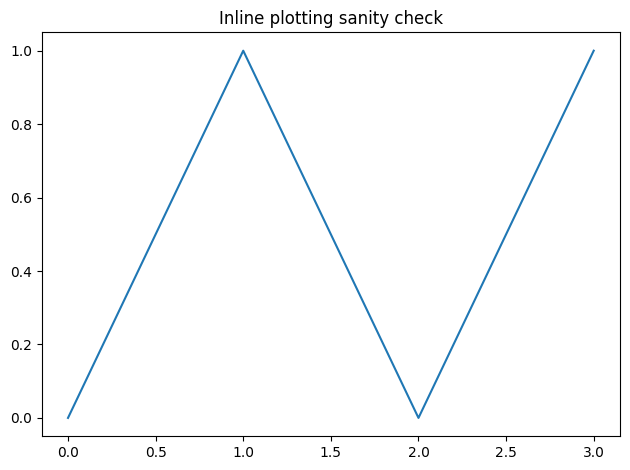

Saved figures in FIG_DIR: /content/drive/MyDrive/Colab Notebooks/models/figs_ser
[]


In [ ]:
import os, glob
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

FIG_DIR = "/content/drive/MyDrive/Colab Notebooks/models/figs_ser"
os.makedirs(FIG_DIR, exist_ok=True)

# A) sanity: a simple plot should appear inline
plt.figure()
plt.plot([0,1,0,1])
plt.title("Inline plotting sanity check")
plt.tight_layout()
plt.show()

# B) list any saved figures
print("Saved figures in FIG_DIR:", FIG_DIR)
print(sorted([os.path.basename(p) for p in glob.glob(os.path.join(FIG_DIR, "*.png"))]))

# C) display any found figures inline
for p in sorted(glob.glob(os.path.join(FIG_DIR, "*.png"))):
    print("Showing:", os.path.basename(p))
    display(Image.open(p))


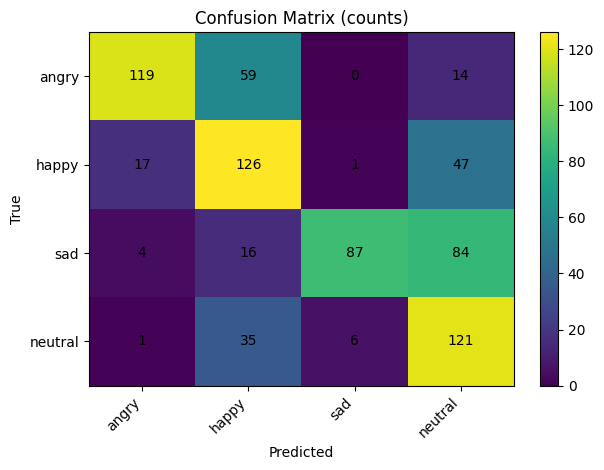

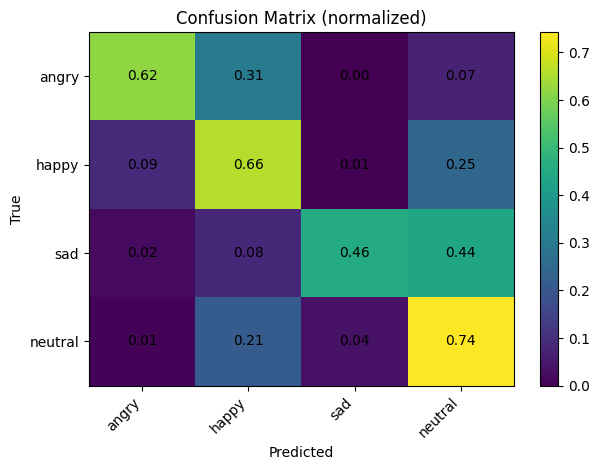


Classification report:
              precision    recall  f1-score   support

       angry     0.8440    0.6198    0.7147       192
       happy     0.5339    0.6597    0.5902       191
         sad     0.9255    0.4555    0.6105       191
     neutral     0.4549    0.7423    0.5641       163

    accuracy                         0.6147       737
   macro avg     0.6896    0.6193    0.6199       737
weighted avg     0.6987    0.6147    0.6221       737



In [ ]:
def plot_cm(y_true_idx, y_pred_idx, classes, normalize=False, title=None):
    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=np.arange(len(classes)))
    if normalize:
        cm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
        t = title or "Confusion Matrix (normalized)"
        fmt = ".2f"
    else:
        t = title or "Confusion Matrix (counts)"
        fmt = "d"

    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(t)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(np.arange(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(np.arange(len(classes)), classes)
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    plt.tight_layout()
    plt.show()

# prediction
# Ensure X_test, y_test, model, and classes are available from previous cells
if 'X_test' in locals() and 'y_test' in locals() and 'model' in locals() and 'classes' in locals():
    y_true_idx = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred_idx = np.argmax(y_pred_probs, axis=1)

    # ---- plot + report ----
    plot_cm(y_true_idx, y_pred_idx, classes, normalize=False)  # counts
    plot_cm(y_true_idx, y_pred_idx, classes, normalize=True)   # normalized

    print("\nClassification report:")
    print(classification_report(y_true_idx, y_pred_idx, target_names=classes, digits=4))
else:
    print("Skipping confusion matrix and classification report. Ensure training was run or model/data were loaded.")

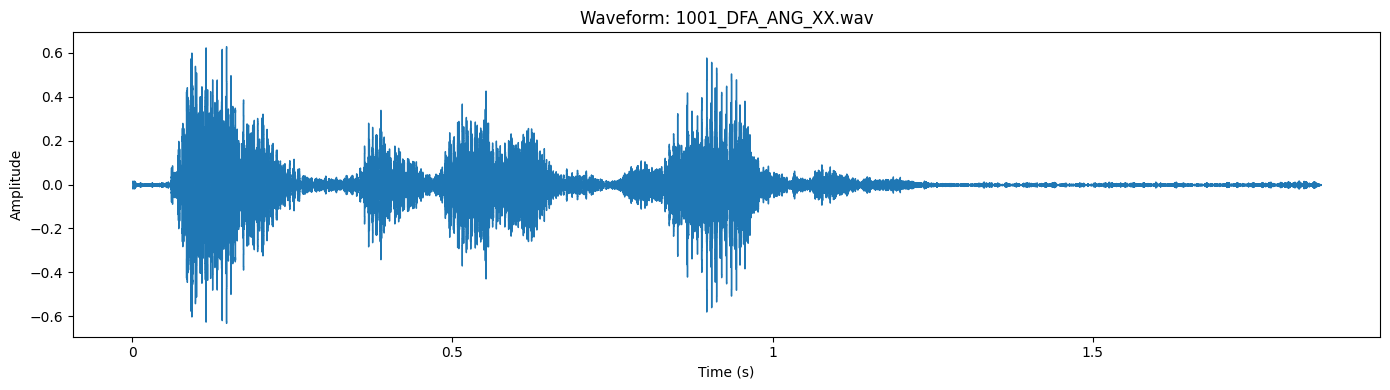

In [4]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

demo_path = "/content/drive/MyDrive/Colab Notebooks/Speech Data/1001_DFA_ANG_XX.wav"
y, sr = librosa.load(demo_path, sr=16000)
y, _ = librosa.effects.trim(y, top_db=30)

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {os.path.basename(demo_path)}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Play audio (make sure to use `display()` in Colab)
display(Audio(y, rate=sr))

In [ ]:
%matplotlib inline

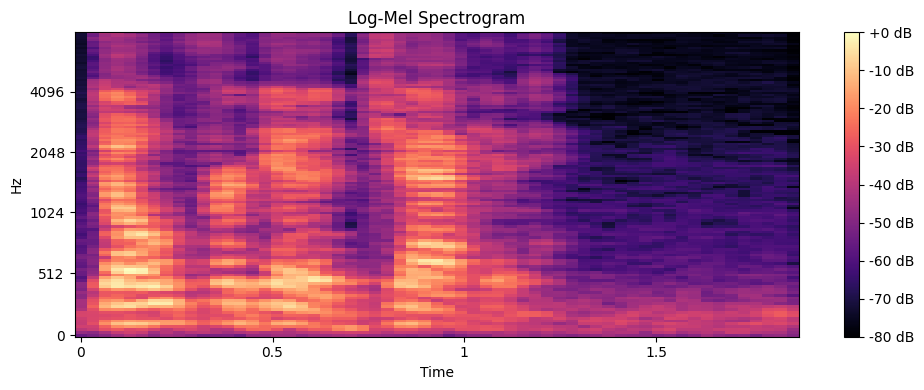

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# === CONFIG ===
file_path = "/content/drive/MyDrive/Colab Notebooks/Speech Data/1001_DFA_ANG_XX.wav"

# === Load and trim audio ===
y, sr = librosa.load(file_path, sr=16000)
y, _ = librosa.effects.trim(y, top_db=30)

# === Compute log-mel spectrogram ===
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmin=30, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)

# === Plot ===
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

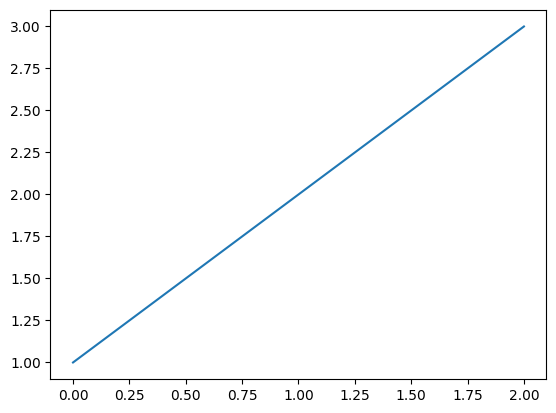

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3])
plt.show()

In [ ]:
import os, re, glob, random
import numpy as np
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# SINGLE-FILE CONFIG
FILE_PATH   = "/content/drive/MyDrive/Colab Notebooks/Speech Data/1001_TSI_SAD_XX.wav"
MODEL_PATH  = "/content/drive/MyDrive/Colab Notebooks/models/emotion_model.h5"  # the model you saved with ModelCheckpoint
CLASSES_PATH = "/content/drive/MyDrive/Colab Notebooks/models/classes.txt"  # optional (one label per line)

TARGET_SR = 16000
FALLBACK_CLASSES = ["angry","happy","sad","neutral"]

In [ ]:
def load_labels_file(path):
    if path and os.path.isfile(path):
        with open(path, "r", encoding="utf-8") as f:
            labs = [ln.strip() for ln in f if ln.strip()]
        if labs:
            return labs
    return FALLBACK_CLASSES

def extract_features(file_path, target_sr=TARGET_SR, n_mfcc=40, max_pad_len=200):
    """Return standardized MFCCs shaped (time=max_pad_len, features=n_mfcc)."""
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    if y.size == 0:
        raise ValueError(f"{os.path.basename(file_path)} trimmed to silence.")
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)   # (n_mfcc, T)
    T = mfcc.shape[1]
    if T < max_pad_len:
        pad = max_pad_len - T
        mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode="constant")
    else:
        mfcc = mfcc[:, :max_pad_len]
    X = mfcc.T.astype(np.float32)                            # (T, n_mfcc)
    mu, sigma = X.mean(axis=0, keepdims=True), X.std(axis=0, keepdims=True) + 1e-6
    return (X - mu) / sigma


In [ ]:
def align_to_model(X_tf, model_input_shape):

    shape = model_input_shape[0] if isinstance(model_input_shape, list) else model_input_shape
    if len(shape) == 3:
        _, T_exp, F_exp = shape; add_channel = False
    elif len(shape) == 4:
        _, T_exp, F_exp, _ = shape; add_channel = True
    else:
        raise ValueError(f"Unexpected model input shape: {shape}")

    t, f = X_tf.shape

    # Center pad/crop time to T_exp if given
    if T_exp is not None and t != T_exp:
        if t < T_exp:
            pad = T_exp - t; left = pad // 2; right = pad - left
            X_tf = np.pad(X_tf, ((left,right),(0,0)), mode="constant")
        else:
            start = (t - T_exp)//2
            X_tf = X_tf[start:start+T_exp, :]

    if F_exp is not None and X_tf.shape[1] != F_exp:
        raise ValueError(f"MFCC feature mismatch: have {X_tf.shape[1]}, model expects {F_exp}. "
                         f"Re-extract with n_mfcc={F_exp}.")

    Xb = X_tf[np.newaxis, ...]  # (1, time, features)
    if add_channel:
        Xb = Xb[..., np.newaxis]  # (1, time, features, 1)
    return Xb, (T_exp, F_exp)

In [ ]:
def predict_single(file_path, model_path, classes_path=None):
    assert os.path.isfile(file_path), f"Audio not found: {file_path}"
    assert os.path.isfile(model_path), f"Model not found: {model_path}"

    # Load model + labels
    model = tf.keras.models.load_model(model_path, compile=False)
    labels = load_labels_file(classes_path)
    shape  = model.input_shape[0] if isinstance(model.input_shape, list) else model.input_shape
    if len(shape) == 3:
        _, T_exp, F_exp = shape
    elif len(shape) == 4:
        _, T_exp, F_exp, _ = shape
    else:
        raise ValueError(f"Unexpected input shape: {shape}")

    # Extract features with the right dims read from the model
    n_mfcc = F_exp if F_exp is not None else 40
    max_pad_len = T_exp if T_exp is not None else 200
    X_tf = extract_features(file_path, target_sr=TARGET_SR, n_mfcc=n_mfcc, max_pad_len=max_pad_len)

    # Align and predict
    Xb, _ = align_to_model(X_tf, model.input_shape)
    probs = model.predict(Xb, verbose=0)[0]
    idx   = int(np.argmax(probs))
    label = labels[idx] if idx < len(labels) else f"class_{idx}"

    print(f"\n🎧 File: {os.path.basename(file_path)}")
    print(f"Predicted Emotion: {label}")
    print("\nClass probabilities:")
    for i, p in enumerate(probs):
        name = labels[i] if i < len(labels) else f"class_{i}"
        print(f"  {name:<10s}: {p:.4f}")

    return label, probs, labels

In [ ]:
if __name__ == "__main__":
    predict_single(FILE_PATH, MODEL_PATH, CLASSES_PATH)


🎧 File: 1001_TSI_SAD_XX.wav
✅ Predicted Emotion: 2

Class probabilities:
  0         : 0.0000
  1         : 0.0090
  2         : 0.9875
  3         : 0.0035


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

FIG_DIR = "/content/drive/MyDrive/Colab Notebooks/models/figs_transformer"
os.makedirs(FIG_DIR, exist_ok=True)


🧪 Test Accuracy: 0.6147 | Test Loss: 0.9221


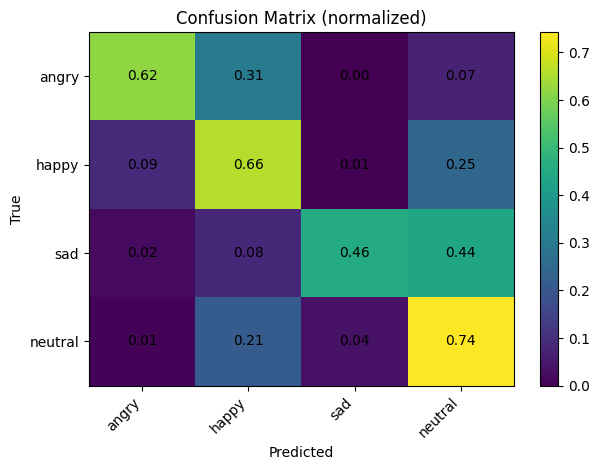

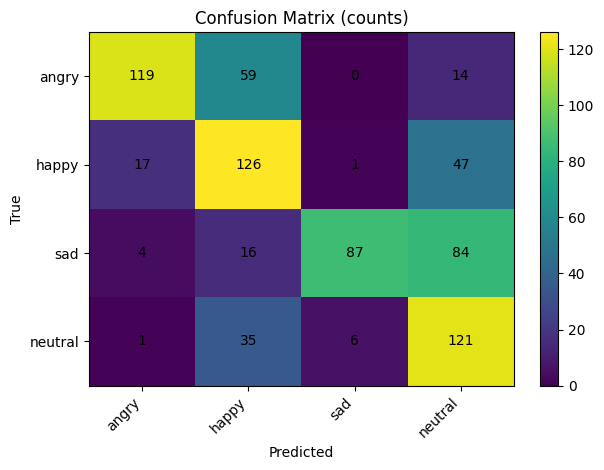


Classification report:
              precision    recall  f1-score   support

       angry     0.8440    0.6198    0.7147       192
       happy     0.5339    0.6597    0.5902       191
         sad     0.9255    0.4555    0.6105       191
     neutral     0.4549    0.7423    0.5641       163

    accuracy                         0.6147       737
   macro avg     0.6896    0.6193    0.6199       737
weighted avg     0.6987    0.6147    0.6221       737



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🧪 Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Predictions for confusion matrix
y_pred_probs = model.predict(X_test, verbose=0)
y_true_idx   = np.argmax(y_test, axis=1)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)

# Confusion matrices (saved + shown)
plot_cm(y_true_idx, y_pred_idx, classes, normalize=True,  title="Confusion Matrix (normalized)")
plot_cm(y_true_idx, y_pred_idx, classes, normalize=False, title="Confusion Matrix (counts)")

print("\nClassification report:")
print(classification_report(y_true_idx, y_pred_idx, target_names=classes, digits=4))
# print(f"Figures saved to: {FIG_DIR}") # Re-enable if you add saving logic to plot_cm

In [ ]:
X, y_cat, classes = make_dataset_from_folder(DATA_DIR)
print(f"Dataset: X={X.shape}, y={y_cat.shape}, classes={classes}")

Files per selected class: {'angry': 1275, 'happy': 1273, 'neutral': 1090, 'sad': 1275}
Segments per class (after windowing): {'angry': 1275, 'happy': 1273, 'neutral': 1090, 'sad': 1275}
Dataset: X=(4913, 64, 101, 1), y=(4913, 4) | classes=['angry', 'happy', 'sad', 'neutral']
Dataset: X=(4913, 64, 101, 1), y=(4913, 4), classes=['angry', 'happy', 'sad', 'neutral']


In [ ]:
def plot_class_histogram(y_onehot, classes, save_name=None):
    """Plot a histogram of class distribution."""
    if not isinstance(y_onehot, np.ndarray) or y_onehot.ndim != 2:
        raise ValueError("y_onehot must be a 2D numpy array (N, num_classes)")

    class_counts = np.sum(y_onehot, axis=0)
    if len(class_counts) != len(classes):
         # Fallback if class names don't match counts (e.g. loaded with fallback classes)
         classes = [f"class_{i}" for i in range(len(class_counts))]

    plt.figure(figsize=(8, 5))
    plt.bar(classes, class_counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Segments")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    if save_name:
        try:
            save_path = os.path.join(FIG_DIR, save_name)
            plt.savefig(save_path)
            print(f"Saved histogram to: {save_path}")
        except Exception as e:
            print(f"Could not save figure: {e}")
    plt.show()

Saved histogram to: /content/drive/MyDrive/Colab Notebooks/models/figs_transformer/class_histogram.png


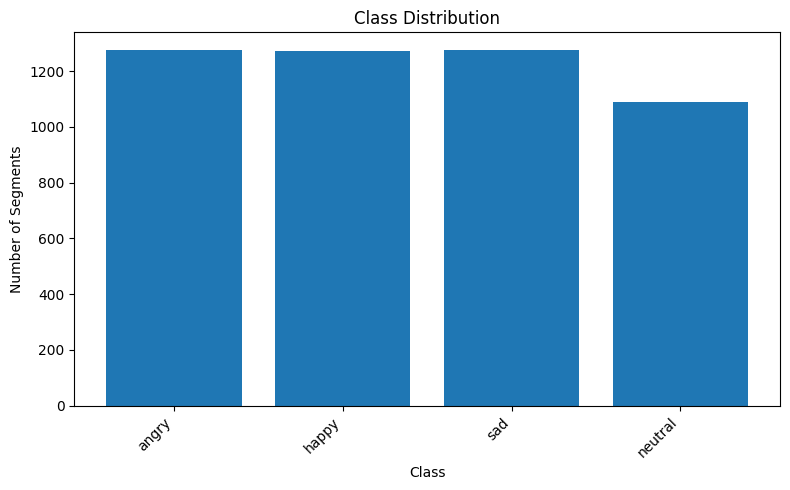

In [ ]:
plot_class_histogram(y_cat, classes, save_name="class_histogram.png")

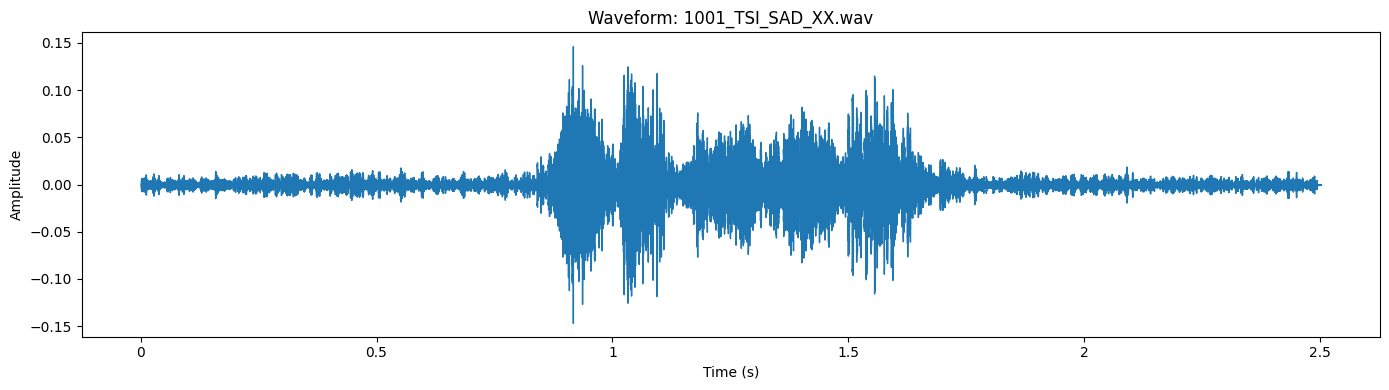

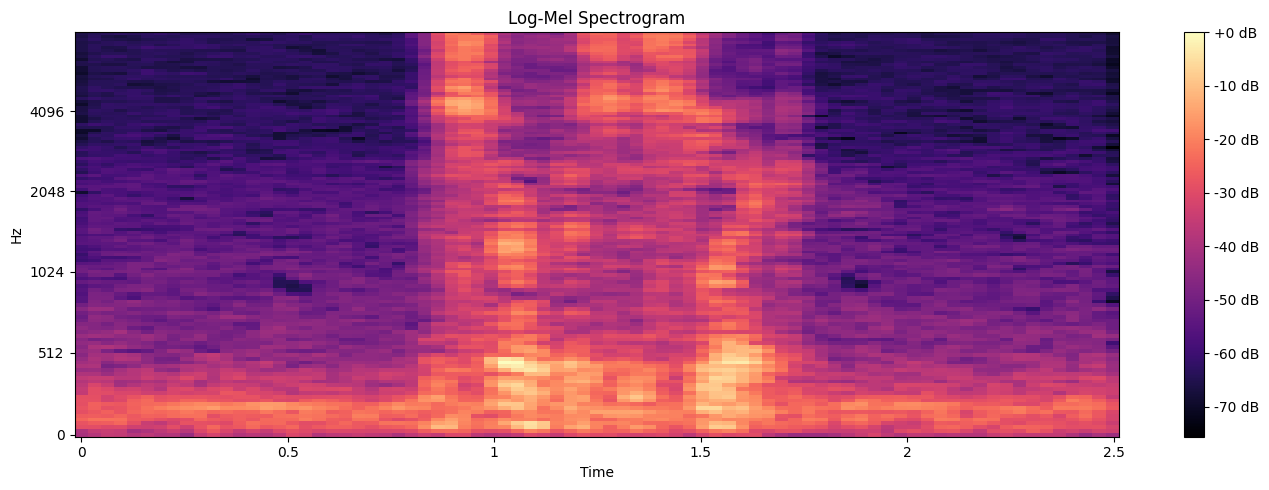

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os # Import os module
import numpy as np

def visualize_audio(file_path, sr=16000):
    # 1. Load and trim audio
    y, _ = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=30)

    # 2. Plot waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # 3. Plot log-mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmin=30, fmax=8000)
    log_S = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(14, 5))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.title('Log-Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    # 4. Playback audio
    display(Audio(y, rate=sr))

# Run it after training
visualize_audio("/content/drive/MyDrive/Colab Notebooks/Speech Data/1001_TSI_SAD_XX.wav")